In [65]:
import torch.nn.functional as F
import torch
from torch_geometric.nn import Sequential, GCNConv

import numpy as np
from pgmpy.metrics import correlation_score
from pgmpy.base import DAG
from pgmpy.models import BayesianNetwork
import networkx as nx
from scipy.stats import chi2_contingency
import pandas as pd

import bnlearn as bn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [181]:
# from torch_geometric.nn.models import GAT
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.explain import AttentionExplainer, ModelConfig, ExplainerConfig, Explainer, GNNExplainer

In [363]:
def undirected_SHD(g1, g2):
    g1 = np.tril(((g1 + g1.T) > 0).astype(int))
    g2 = np.tril(((g2 + g2.T) > 0).astype(int))
    return np.sum(np.abs(g1-g2))

In [364]:
def comb_SHD(g1, g2):
    return np.sum(np.abs(g1 - g2)), undirected_SHD(g1,g2)

In [373]:
num_samples = 10000
file_name = "insurance"
model_asia = bn.import_DAG("BIFs/" + file_name + ".bif")
df_asia = bn.sampling(model_asia, n=num_samples)
# df_asia = df_asia.drop(file_name, axis=1)
nodes_orig = list(model_asia['adjmat'].columns)
asia_dag = DAG(model_asia['adjmat'])

[bnlearn] >Import <BIFs/insurance.bif>
[bnlearn] >Loading bif file <BIFs/insurance.bif>


[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
[setgraphviz] >WARNING> Probability value

[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [Accident] does not add up to 1 but is: [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
[bnlearn] >CPD [CarValue] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn] >CPD [DrivHist] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >CPD [DrivingSkill] does not add up to 1 but is: [[1. 1.]
 [1. 1.]
 [1. 1.]]
[bnlearn] >CPD [HomeBase] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >CPD [MedCost] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn]

In [374]:
df_asia.T.to_numpy().shape

(27, 10000)

[setgraphviz] >INFO> System found: osx
[setgraphviz] >INFO> The OS is not supported to automatically set Graphviz in the system env.
[setgraphviz] >INFO> Graphviz path found in environment.


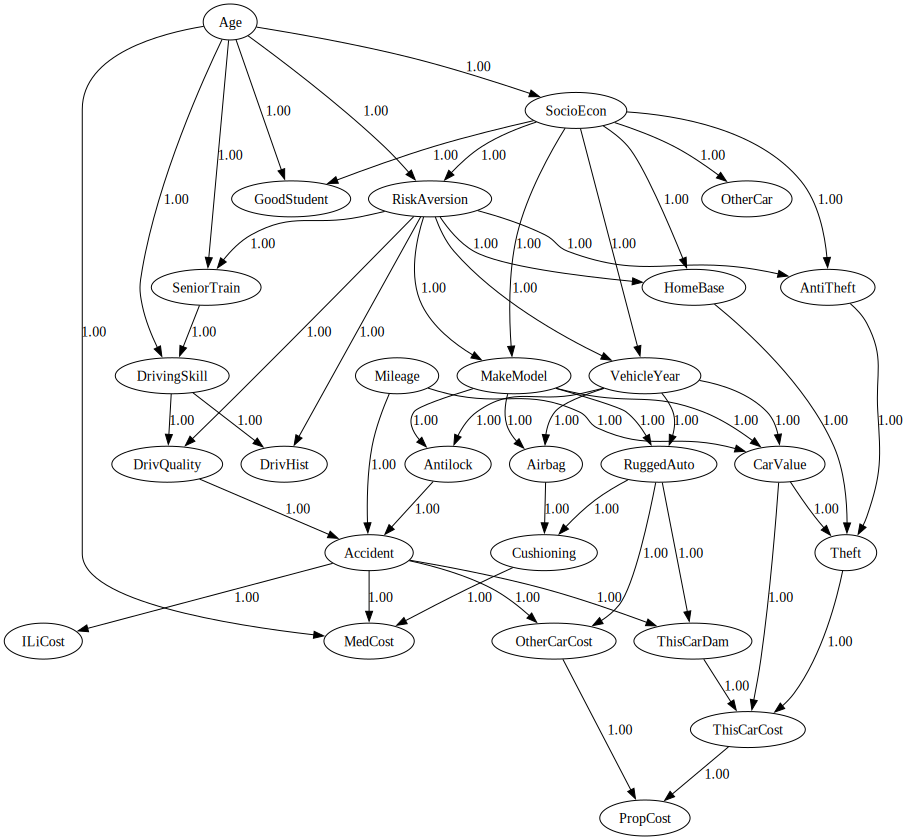

In [375]:
bn.plot_graphviz(model_asia)

In [376]:
df_asia.to_numpy()

array([[2, 1, 1, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 0],
       [2, 1, 2, ..., 1, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 0, 2],
       [0, 1, 1, ..., 1, 0, 0],
       [1, 1, 2, ..., 0, 0, 0]])

In [417]:
edge_index = []
for i in range(len(df_asia.columns)):
    for j in range(i+1, len(df_asia.columns)):
        edge_index.append([i,j])
        edge_index.append([j,i])
edge_index = torch.tensor(np.array(edge_index))

In [466]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads)
        self.conv2 = GATConv(hidden_channels* heads, hidden_channels, heads, dropout=0)
        self.conv3 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv3(x, edge_index)
        return x

In [467]:
data = Data()

In [468]:
data.x = torch.tensor(df_asia.T.to_numpy().astype("float32"))
data.edge_index = edge_index.t().contiguous()

In [469]:
adj_mat_size = len(df_asia.columns)

model = GAT(data.num_features, 100, data.num_features, adj_mat_size)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

In [471]:
model(data.x, data.edge_index).shape

torch.Size([27, 10000])

In [472]:
target = torch.tensor(model_asia['adjmat'].astype(int).to_numpy().astype("float32"))

In [473]:
model.train()
losses = []
for e in tqdm(range(100)):
    optim.zero_grad()
    out = model(data.x, data.edge_index)
    loss1 = loss_fn(data.x, out)
    loss1.backward()
    
    optim.step()
    losses.append(loss1.item())


00%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.15it/s]

In [474]:
model(data.x, data.edge_index).shape

torch.Size([27, 10000])

In [475]:
model.conv1.att_dst.detach().numpy()[0].shape

(27, 100)

In [476]:
model.conv1.att_dst.detach().numpy()[0]

array([[ 0.02321145,  0.13384114, -0.23028012, ..., -0.1077688 ,
         0.2561939 , -0.06263844],
       [-0.01599094, -0.16538548,  0.14726058, ..., -0.10414315,
        -0.0359097 ,  0.1459648 ],
       [ 0.03747515,  0.2224477 , -0.03702009, ...,  0.25493994,
         0.34923515,  0.2631955 ],
       ...,
       [-0.1690107 ,  0.12787476,  0.15176885, ...,  0.06565682,
         0.09373303, -0.20330025],
       [-0.19798753, -0.0782149 , -0.13868445, ..., -0.03968324,
         0.0516752 , -0.03686824],
       [ 0.13817935, -0.10498392,  0.08747531, ..., -0.01586856,
        -0.06844407, -0.06099031]], dtype=float32)

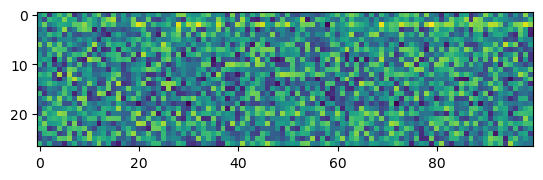

In [477]:
plt.imshow(model.conv1.att_dst.detach().numpy()[0])

In [478]:
model.conv1.att_src.detach().numpy().shape

(1, 27, 100)

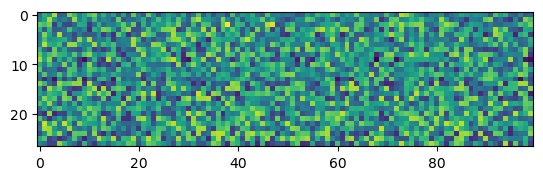

In [479]:
plt.imshow(model.conv1.att_src.detach().numpy()[0])

In [498]:
explainer = Explainer(
    model = model, 
    explanation_type="model",
    algorithm=AttentionExplainer(reduce="mean"),
    node_mask_type=None,
    edge_mask_type='object',
    model_config = ModelConfig(
        mode='binary_classification',
        task_level='edge',
        return_type='raw'
    )
)

In [499]:
explanation = explainer(
    data.x, data.edge_index
)

In [500]:
explanation.available_explanations

['edge_mask']

In [501]:
explanation['edge_mask']

tensor([0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0370, 0.0247, 0.0247, 0.0247,
        0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247,
        0.0247, 0.0247, 0.0247, 0.0494, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247,
        0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247,
        0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0370, 0.0247,
        0.0247, 0.0247, 0.0247, 0.0247, 0.3086, 0.0247, 0.0247, 0.0247, 0.0247,
        0.0247, 0.0370, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247,
        0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0494,
        0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247,
        0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247,
        0.0247, 0.0247, 0.0247, 0.0370, 0.0247, 0.0247, 0.0247, 0.0247, 0.0247,
        0.3086, 0.0247, 0.0247, 0.0247, 0.0370, 0.0247, 0.0247, 0.0247, 0.0247,
        0.0247, 0.0247, 0.0247, 0.0247, 

In [502]:
max(explanation['edge_mask'])

tensor(0.3086)

In [503]:
torch.std(explanation['edge_mask'])

tensor(0.0536)

In [504]:
torch.mean(explanation['edge_mask'])

tensor(0.0370)

In [505]:
# att_thresh = (explanation['edge_mask'] > torch.mean(explanation['edge_mask']) + 0.82 * torch.std(explanation['edge_mask'])).detach().numpy().astype(int)
att_thresh = explanation['edge_mask'] == max(explanation['edge_mask'])

In [506]:
temp_adj = np.zeros((adj_mat_size, adj_mat_size), dtype=int)
for i in range(len(att_thresh)):
    if att_thresh[i] == 1:
        print(edge_index[i].detach().numpy())
        idx = edge_index[i].detach().numpy()
        temp_adj[idx[0]][idx[1]] = 1

[25  0]
[25  1]
[25  2]
[25  3]
[25  4]
[25  5]
[25  6]
[25  7]
[25  8]
[25  9]
[25 10]
[25 11]
[25 12]
[25 13]
[25 14]
[25 15]
[25 16]
[25 17]
[25 18]
[25 19]
[25 20]
[25 21]
[25 22]
[25 23]
[25 24]
[25 26]


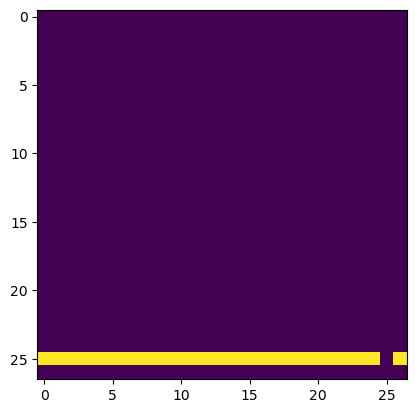

In [507]:
plt.imshow(temp_adj)

In [508]:
comb_SHD(temp_adj, model_asia['adjmat'].astype(int).to_numpy())

(78, 76)

In [509]:
g = nx.DiGraph(temp_adj, nodes=df_asia.columns)

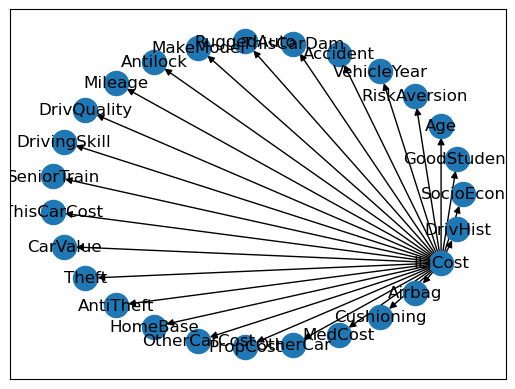

In [510]:
pos = nx.circular_layout(g)
nx.draw_networkx(g, pos, labels = {
    i:df_asia.columns[i] for i in range(len(g.nodes))
})

In [494]:
explanation.visualize_graph(node_labels=df_asia.columns)

In [360]:
max(losses)

6192.29296875

In [282]:
min(losses)

0.12791305780410767

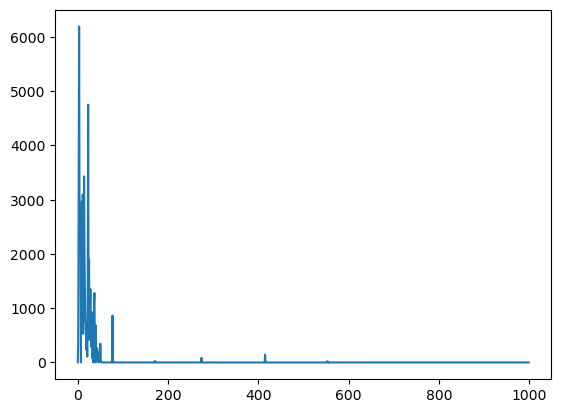

In [283]:
plt.plot(losses)